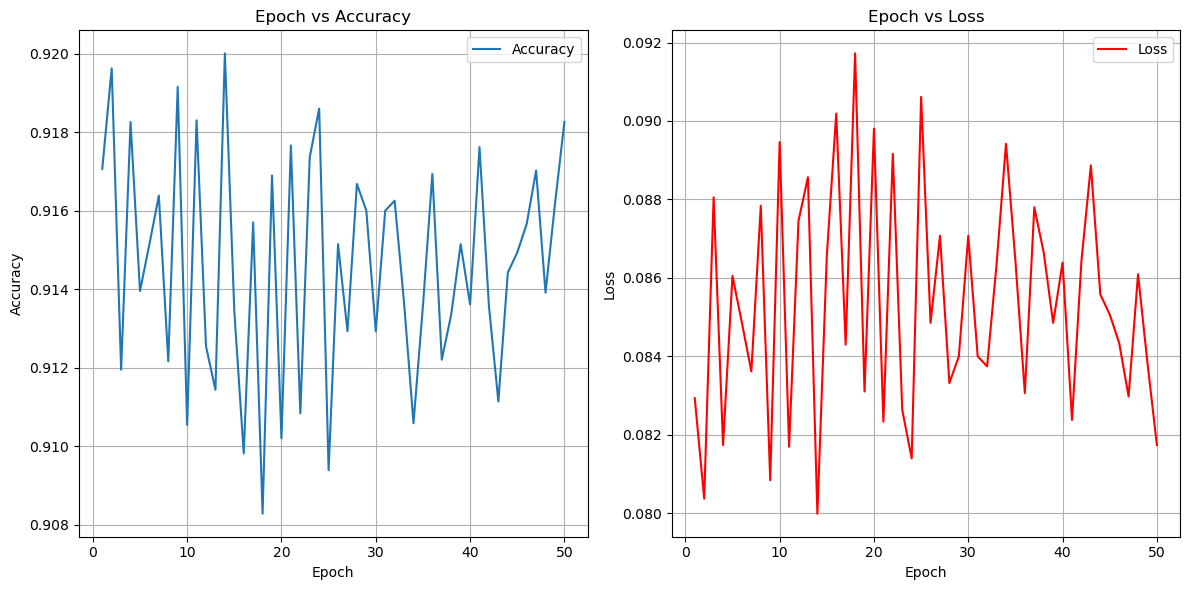

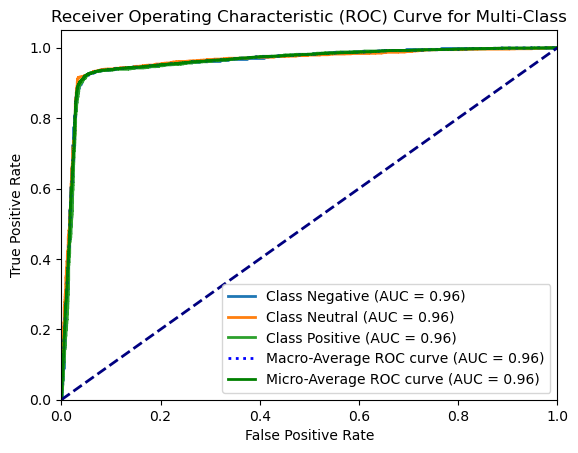

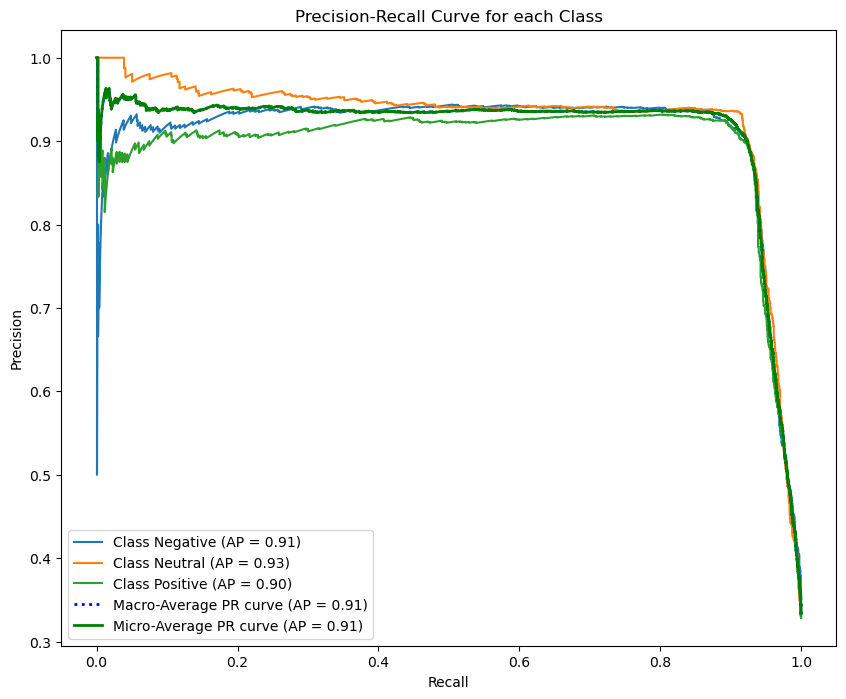


Average Precision for each class:
Class Negative: 91.01%
Class Neutral: 92.70%
Class Positive: 89.54%

Classification Report:
Class          Precision Recall    F1-Score  Support
Negative       92.55     90.25     91.39     1928.0
Neutral        92.37     91.77     92.07     2006.0
Positive       89.38     92.21     90.77     1926.0
macro avg      91.44     91.41     91.41     5860.0
weighted avg   91.45     91.42     91.42     5860.0

Accuracy: 91.42%
F1-Score (Weighted): 91.42%

Confusion Matrix:
[[1740   48  140]
 [  94 1841   71]
 [  46  104 1776]]


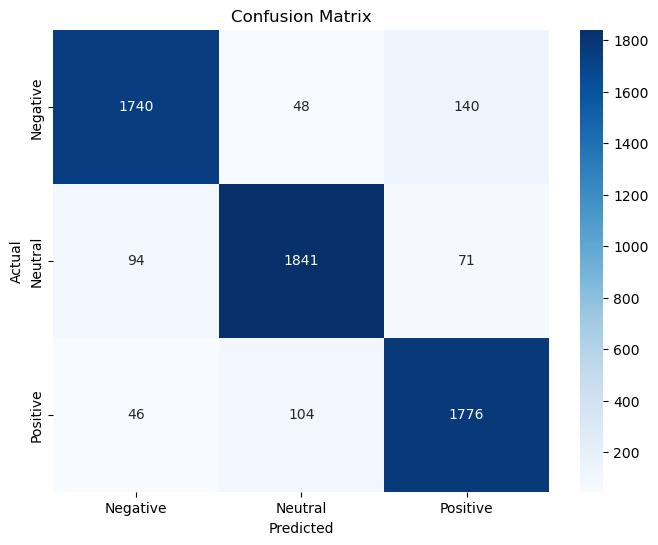

In [6]:
import numpy as np  # Import numpy to handle random operations
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_curve, auc, average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Load the dataset from the provided file path
file_path = r"D:\10080\Merged data.xlsx"
data = pd.read_excel(file_path)

# Preprocessing: Convert text data into numerical form using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_df=0.85, min_df=3)

# Prepare the features and labels
X = data['Review']
y = data['Statement']

# Encoding the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Fit the TF-IDF Vectorizer on the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train the Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)

# Initialize lists to track performance for the convergence curve
accuracy_history = []
loss_history = []

# Simulating "epochs" by manually training over different subsets of the training data (mini-batches)
epochs = 50
batch_size = int(len(X_train) / 10)  # Use 10 mini-batches
for epoch in range(epochs):
    # Simulate mini-batch training by training on a random subset of the data
    indices = list(range(len(X_train)))
    np.random.shuffle(indices)  # Use numpy to shuffle indices
    
    # Take mini-batch for the current epoch
    batch_indices = indices[:batch_size]
    
    # Train the model on this mini-batch
    svm_model.fit(X_train_tfidf[batch_indices], y_train[batch_indices])
    
    # Track the training accuracy
    y_train_pred = svm_model.predict(X_train_tfidf)
    accuracy_history.append(accuracy_score(y_train, y_train_pred))
    
    # Calculate the "loss" as 1 - accuracy for the purpose of the convergence curve
    loss_history.append(1 - accuracy_history[-1])

# Plotting the Convergence Curve
plt.figure(figsize=(12, 6))

# Plot Epoch vs Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), accuracy_history, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.grid(True)
plt.legend()

# Plot Epoch vs Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), loss_history, label='Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Predictions on the test set
y_pred = svm_model.predict(X_test_tfidf)

# Classification Report and other metrics
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# F1-Score
f1 = f1_score(y_test, y_pred, average='weighted')

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Binarize the labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
y_pred_prob = svm_model.predict_proba(X_test_tfidf)

# Calculate the ROC curve for each class (without overall ROC curve)
fpr_dict = {}
tpr_dict = {}
roc_auc_dict = {}
for i in range(len(label_encoder.classes_)):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
    roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

# Calculate the Macro-Average ROC Curve by averaging the per-class FPR and TPR
fpr_macro, tpr_macro, _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc_macro = auc(fpr_macro, tpr_macro)

# Calculate the Micro-Average ROC Curve (treats the multi-class problem as one binary problem)
fpr_micro, tpr_micro, _ = roc_curve(y_test_binarized.ravel(), y_pred_prob.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plotting the ROC Curve for each class (including Macro and Micro averages)
plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr_dict[i], tpr_dict[i], lw=2, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc_dict[i]:0.2f})')

# Plotting the Macro-Average and Micro-Average ROC curves
plt.plot(fpr_macro, tpr_macro, color='blue', lw=2, linestyle=':', label=f'Macro-Average ROC curve (AUC = {roc_auc_macro:.2f})')
plt.plot(fpr_micro, tpr_micro, color='green', lw=2, linestyle='-', label=f'Micro-Average ROC curve (AUC = {roc_auc_micro:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall curve for each class
precision_dict = {}
recall_dict = {}
average_precision_dict = {}

# Calculate Precision-Recall for each class
for i in range(len(label_encoder.classes_)):
    precision_dict[i], recall_dict[i], _ = precision_recall_curve(
        y_test_binarized[:, i], y_pred_prob[:, i]
    )
    average_precision_dict[i] = average_precision_score(
        y_test_binarized[:, i], y_pred_prob[:, i]
    )

# Calculate Macro-Average Precision-Recall curve
precision_macro, recall_macro, _ = precision_recall_curve(
    y_test_binarized.ravel(), y_pred_prob.ravel()
)
average_precision_macro = average_precision_score(
    y_test_binarized.ravel(), y_pred_prob.ravel()
)

# Calculate Micro-Average Precision-Recall curve
precision_micro, recall_micro, _ = precision_recall_curve(
    y_test_binarized.ravel(), y_pred_prob.ravel()
)
average_precision_micro = average_precision_score(
    y_test_binarized.ravel(), y_pred_prob.ravel()
)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(label_encoder.classes_)):
    plt.plot(recall_dict[i], precision_dict[i], label=f'Class {label_encoder.classes_[i]} (AP = {average_precision_dict[i]:.2f})')

# Add Macro-Average and Micro-Average Precision-Recall curves
plt.plot(recall_macro, precision_macro, color='blue', lw=2, linestyle=':', label=f'Macro-Average PR curve (AP = {average_precision_macro:.2f})')
plt.plot(recall_micro, precision_micro, color='green', lw=2, linestyle='-', label=f'Micro-Average PR curve (AP = {average_precision_micro:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each Class')
plt.legend(loc='best')
plt.show()

# Display the average precision for each class in percentage
print("\nAverage Precision for each class:")
for i in range(len(label_encoder.classes_)):
    print(f"Class {label_encoder.classes_[i]}: {average_precision_dict[i] * 100:.2f}%")

# Displaying results in percentage format
print("\nClassification Report:")
print(f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F1-Score':<10}{'Support'}")
for label, metrics in class_report.items():
    if label != 'accuracy':  # Skip accuracy row for now
        print(f"{label:<15}{metrics['precision'] * 100:<10.2f}{metrics['recall'] * 100:<10.2f}{metrics['f1-score'] * 100:<10.2f}{metrics['support']}")

# Accuracy in percentage
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# F1-Score (Weighted) in percentage
print(f"F1-Score (Weighted): {f1 * 100:.2f}%")

# Confusion Matrix
print("\nConfusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix using seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
